In [1]:
from feeder import tools
import torch
import pickle
import numpy as np

In [2]:
class Feeder(torch.utils.data.Dataset):
    """ Feeder for skeleton-based action recognition
    Arguments:
        data_path: the path to '.npy' data, the shape of data should be (N, C, T, V, M)
        label_path: the path to label
        random_choose: If true, randomly choose a portion of the input sequence
        random_shift: If true, randomly pad zeros at the begining or end of sequence
        window_size: The length of the output sequence
        normalization: If true, normalize input sequence
        debug: If true, only use the first 100 samples
    """

    def __init__(self,
                 data_path,
                 label_path,
                 random_choose=False,
                 random_move=False,
                 window_size=-1,
                 debug=False,
                 mmap=True):
        self.debug = debug
        self.data_path = data_path
        self.label_path = label_path
        self.random_choose = random_choose
        self.random_move = random_move
        self.window_size = window_size

        self.load_data(mmap)

    def load_data(self, mmap):
        # data: N C V T M

        # load label
        with open(self.label_path, 'rb') as f:
            self.sample_name, self.label = pickle.load(f)

        # load data
        if mmap:
            self.data = np.load(self.data_path, mmap_mode='r')
        else:
            self.data = np.load(self.data_path)

        if self.debug:
            self.label = self.label[0:100]
            self.data = self.data[0:100]
            self.sample_name = self.sample_name[0:100]

        self.N, self.C, self.T, self.V, self.M = self.data.shape

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        # get data
        data_numpy = np.array(self.data[index])
        label = self.label[index]

        # processing
        if self.random_choose:
            data_numpy = tools.random_choose(data_numpy, self.window_size)
        elif self.window_size > 0:
            data_numpy = tools.auto_pading(data_numpy, self.window_size)
        if self.random_move:
            data_numpy = tools.random_move(data_numpy)

        return data_numpy, label

In [3]:
def resize(x):
    N, C, T, V, M = x.size()
    x = x.permute(0, 4, 3, 1, 2).contiguous()
    x = x.view(N * M, V * C * T)
    return x

In [4]:
data_path = "./data/NTURGBD-sharing/xsub/val_data.npy"
label_path = "./data/NTURGBD-sharing/xsub/val_label.pkl"
dset = Feeder(data_path, label_path)
data_loader = torch.utils.data.DataLoader(
        dataset=dset,
        batch_size=64,
        shuffle=False)

In [6]:
img = []
label = []
for data, cl in data_loader:
    for i in range (len(cl)):
        img.append(data[i].numpy())
        label.append(cl[i].numpy())

In [8]:
np.shape(img)

(1097, 3, 300, 25, 2)

In [9]:
np.shape(label)

(1097,)

In [11]:
tsne_data = resize(torch.tensor(img))

In [12]:
tsne_data.shape

torch.Size([2194, 22500])

In [13]:
data = tsne_data[::2,]
label = np.array(label)
print(data.shape)
print(label.shape)

torch.Size([1097, 22500])
(1097,)


In [14]:
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.manifold import TSNE

def map_label(lable_num):
    if lable_num == 9:
        color = 1
    elif lable_num == 11:
        color = 2
    elif lable_num == 52:
        color = 3
    elif lable_num == 55:
        color = 4
    return color

def plot_embedding_2D(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    fig = plt.figure()
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(map_label(label[i])),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig
def plot_embedding_3D(data,label,title): 
    x_min, x_max = np.min(data,axis=0), np.max(data,axis=0) 
    data = (data- x_min) / (x_max - x_min) 
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d') 
    for i in range(data.shape[0]): 
        ax.text(data[i, 0], data[i, 1], data[i,2],str(label[i]), color=plt.cm.Set1(map_label(label[i])),fontdict={'weight': 'bold', 'size': 9}) 
    return fig

Begining......
Finished......


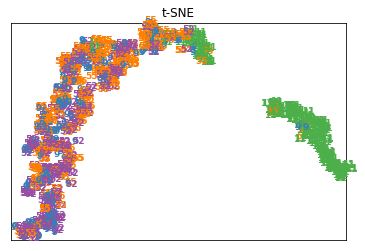

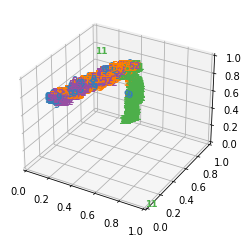

In [15]:
print('Begining......') #时间会较长，所有处理完毕后给出finished提示
tsne_2D = TSNE(n_components=2, init='pca', random_state=0) #调用TSNE
result_2D = tsne_2D.fit_transform(data)
tsne_3D = TSNE(n_components=3, init='pca', random_state=0)
result_3D = tsne_3D.fit_transform(data)
print('Finished......')
#调用上面的两个函数进行可视化
fig1 = plot_embedding_2D(result_2D, label,'t-SNE')
plt.show(fig1)
fig2 = plot_embedding_3D(result_3D, label,'t-SNE')
plt.show(fig2)

In [16]:
np.unique(label)

array([ 9, 11, 52, 55])